We will utilise a similar pipeline implementation from LGBM_ML_Jarvis_Pipeline to train a simple TreeRegressor model, which will then be comared to LBGM as a baseline. 


## Preparing the Data

In [3]:
from jarvis.db.figshare import data
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
df = pd.DataFrame(data("dft_3d"))
df 

AttributeError: partially initialized module 'pandas' from 'c:\Users\nitro\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\__init__.py' has no attribute '_pandas_datetime_CAPI' (most likely due to a circular import)

In [ ]:
#Based on the Accelerated Discovery of Efficient Solar Cell Materials Using Quantum and Machine Learning Methods,
#we are interested in materials with SLME values > 10%
#remove the data that does not have SLME values
df_slme = df[~df['slme'].isin(["na","?"])].copy()
df_slme['slme'] = df_slme.loc[:,'slme'].astype(float)
df_slme["slme_10"] = (df_slme['slme'] >= 10.0).astype(int)
df_slme.replace({"na": np.nan, "?" : np.nan}, inplace=True)
# Remove uncessary columns
df_slme.drop(columns=['jid', 'atoms', 'elastic_tensor', 'effective_masses_300K', 'modes', 'icsd','efg', 'xml_data_link', 'raw_files', 'reference', 'search'], inplace=True)
print(f"Dataframe shape after removing entries with SLME <= 10%: {df_slme.shape}")




Dataframe shape after removing entries with SLME <= 10%: (9770, 54)
Index(['spg_number', 'spg_symbol', 'formula', 'formation_energy_peratom',
       'func', 'optb88vdw_bandgap', 'slme', 'magmom_oszicar', 'spillage',
       'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'encut',
       'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'mepsx', 'mepsy',
       'mepsz', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass',
       'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
       'dfpt_piezo_max_dielectric_electronic',
       'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode',
       'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond',
       'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality',
       'typ', 'exfoliation_energy', 'spg', 'crys', 'density', 'poisson', 'nat',
       'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap',
       'slme_10'],
      dtype='object')


C:\Users\nitro\AppData\Local\Temp\ipykernel_11968\119186936.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_slme.replace({"na": np.nan, "?" : np.nan}, inplace=True)


In [ ]:
# Convert columns to int/float as needed to avoid issues during modeling
col_convert_float = [ 'magmom_oszicar', 'spillage', 'maxdiff_mesh', 'maxdiff_bz', 'epsx', 'epsy', 'epsz',
    'mepsx', 'mepsy', 'mepsz', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass',
    'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
    'dfpt_piezo_max_dielectric_electronic', 'dfpt_piezo_max_dielectric_ionic',
    'max_ir_mode', 'min_ir_mode', 'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact',
    'ncond', 'pcond', 'nkappa', 'pkappa', 'Tc_supercon', 'exfoliation_energy', 'poisson',
    'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap']

for col_name in col_convert_float:
    df_slme[col_name] = df_slme[col_name].fillna(0)
    df_slme.loc[:,col_name] = df_slme[col_name].astype(float)


df_slme.loc[:,'encut'] = df_slme['encut'].fillna(0).astype(int)
df_slme.loc[:,'kpoint_length_unit'] = df_slme['kpoint_length_unit'].fillna(0).astype(int)

print(df_slme.columns)

Index(['spg_number', 'spg_symbol', 'formula', 'formation_energy_peratom',
       'func', 'optb88vdw_bandgap', 'slme', 'magmom_oszicar', 'spillage',
       'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'encut',
       'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'mepsx', 'mepsy',
       'mepsz', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass',
       'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
       'dfpt_piezo_max_dielectric_electronic',
       'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode',
       'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond',
       'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality',
       'typ', 'exfoliation_energy', 'spg', 'crys', 'density', 'poisson', 'nat',
       'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap',
       'slme_10'],
      dtype='object')


## PCA Implementation

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [ ]:
#Set target and remove target variables from features
y_pred_PCA = df_slme['slme']
X_features_PCA = df_slme.select_dtypes(include = ["number"]).drop(columns=['slme','slme_10'])
columns_ = X_features_PCA.columns
feature_columns = X_features_PCA.columns


In [ ]:
#standardise and impute features

simpler = SimpleImputer(strategy='mean')
X_features_PCA = simpler.fit_transform(X_features_PCA)

scaler = StandardScaler()
X_standard = scaler.fit_transform(X_features_PCA)



In [ ]:
#PCA Implementation

pca_optim, pca_list, optimal_components, level_of_val= PCA(n_components = 2), [], 0, 0, 
pca_optim.fit(X_standard)

for i in range(0,X_standard.shape[1]):
    pca = PCA(n_components = i)
    pca.fit(X_standard)
    pca_list.append(pca)   
  
    if (pca.explained_variance_ratio_.sum() >= 0.95 and optimal_components != 0):
        #Transform the data using the optimal number of components
        pca_optim = pca
        
        optimal_components = i
        
    if (len(pca_list) >= 2 and pca_list[-1].explained_variance_ratio_.sum() - pca_list[-2].explained_variance_ratio_.sum() < 0.001): 
        level_of_val = pca_list[-1].explained_variance_ratio_.sum()
        print(f"Convergence reached at {i} components with {level_of_val} variance explained.")
        break
    
#Print explained variance ratio for each component 
print(f"Explained Variance List: \n{pca.explained_variance_ratio_}")
X_pca_transformed = pca_optim.transform(X_standard)
print(X_pca_transformed)



Convergence reached at 39 components with 0.9988779481218816 variance explained.
Explained Variance List: 
[0.15522802 0.08850578 0.07932105 0.06073929 0.04889593 0.04029041
 0.03962874 0.03799761 0.03345474 0.02875318 0.02810926 0.02718674
 0.02401043 0.02282025 0.02254649 0.0216074  0.02111506 0.02067253
 0.0192231  0.01871346 0.01740296 0.01625845 0.01452694 0.0139652
 0.01334125 0.01144775 0.01075634 0.00961442 0.00892477 0.00831591
 0.00647346 0.00622484 0.00533814 0.00443174 0.00353955 0.0033725
 0.00322142 0.00192301 0.00097981]
[[-1.57844102  0.7575733 ]
 [-1.27851649 -0.7334662 ]
 [ 0.38541913  0.70139898]
 ...
 [ 3.62212243 -1.78988932]
 [ 3.71971447 -1.77341478]
 [ 2.16966757 -1.47388548]]
(9770, 54)


In [ ]:
X_pca_df = pd.DataFrame(pca.components_, columns= columns_ , index = [f'PCA {i+1}' for i in range(pca.n_components_) ] )
print(X_pca_df,"/n")
total_contribution =  X_pca_df.abs().sum(axis = 0)
total_contribution = total_contribution.sort_values(ascending = False)
print(total_contribution)  

        formation_energy_peratom  optb88vdw_bandgap  ...  mbj_bandgap   hse_gap
PCA 1                   0.148192          -0.232152  ...    -0.193183 -0.014844
PCA 2                  -0.082780           0.108575  ...     0.098395  0.018420
PCA 3                   0.001894          -0.008577  ...    -0.040556  0.023511
PCA 4                   0.344623          -0.253132  ...    -0.206140  0.013274
PCA 5                  -0.027263          -0.093978  ...    -0.082958 -0.019760
PCA 6                   0.037004           0.056642  ...     0.049971  0.084451
PCA 7                  -0.085712          -0.217676  ...    -0.248457 -0.075540
PCA 8                  -0.079710           0.004186  ...    -0.014920 -0.071111
PCA 9                   0.095040           0.119908  ...     0.150660  0.312563
PCA 10                 -0.063315           0.306879  ...     0.396675 -0.117097
PCA 11                 -0.248462           0.077896  ...     0.096890  0.101453
PCA 12                  0.210935        

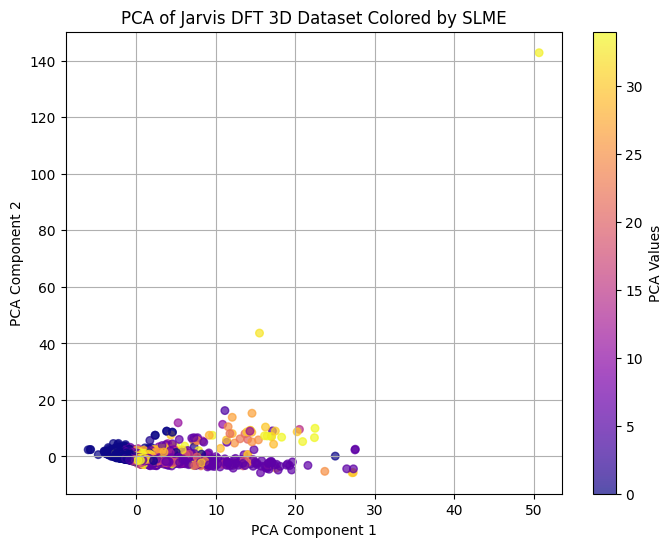

In [ ]:
fig = plt.figure(figsize = (8,6))
plt.scatter(X_pca_transformed[:,0], X_pca_transformed[:,1], c = y_pred_PCA, cmap='plasma', alpha=0.7, s= 30)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Jarvis DFT 3D Dataset Colored by SLME")
plt.grid()

color_bar = plt.colorbar()
color_bar.set_label("PCA Values")




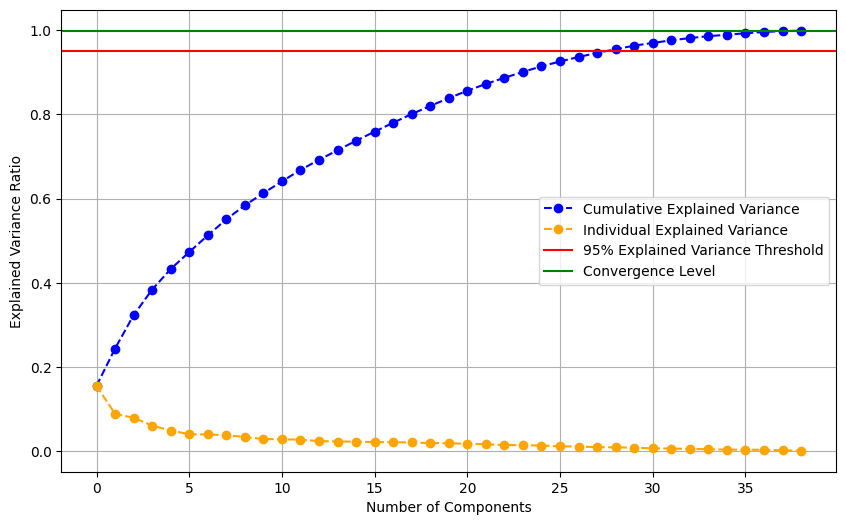

In [ ]:
cummulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize  =(10,6))
plt.plot(np.arange(0,pca.n_components_),cummulative_explained_variance, marker ='o', linestyle ='--', label = 'Cumulative Explained Variance', color='blue')
plt.plot(np.arange(0,pca.n_components_), pca.explained_variance_ratio_, marker ='o', linestyle ='--', color='orange', label = 'Individual Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.axhline(y = 0.95, color = 'r', linestyle = '-', label='95% Explained Variance Threshold')
plt.axhline(y = level_of_val, color = 'g', linestyle = '-', label='Convergence Level')
plt.grid()
plt.legend( )



In [ ]:
from prince import MCA
from sklearn.model_selection import train_test_split
import random

## Preparing the Data
df_categorical_columns = ['spg_number', 'spg_symbol', 'func', 'dimensionality', 'spg', 'crys', 'typ']


for column in df_categorical_columns:
    df[column] = df[column].astype('category').cat.codes
    


X = df_slme.drop(columns = ['slme','slme_10','formula']).select_dtypes(include =["number"])
Y = df_slme['slme_10']
random_seed = random.randint(1,100)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_seed)
test_indices = Y_test.index




Shape  (9770, 55) 

Index(['spg_number', 'spg_symbol', 'formula', 'formation_energy_peratom',
       'func', 'optb88vdw_bandgap', 'slme', 'magmom_oszicar', 'spillage',
       'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'encut',
       'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'mepsx', 'mepsy',
       'mepsz', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass',
       'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
       'dfpt_piezo_max_dielectric_electronic',
       'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode',
       'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond',
       'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality',
       'typ', 'exfoliation_energy', 'spg', 'crys', 'density', 'poisson', 'nat',
       'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap',
       'slme_10', 'labels'],
      dtype='object')


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score, log_loss, roc_auc_score


#Initialize the simple Tree
df_slme_regressor = DecisionTreeRegressor(max_depth  = 5)
#Train the model 
df_slme_regressor.fit(X_train, Y_train)

#Store the Predicted Slme_10 values for later analysis 
Y_pred = df_slme_regressor.predict(X_test)


results = pd.DataFrame({"Formula":df_slme.loc[test_indices, "formula"], "Actual": Y_test, "Predicted": Y_pred.astype(int)})
results.index = [i for i in range(results.shape[0])]

#Display the Results of Training a simple DecisionTreeRegressor 
   
print("Number of materials:", results.shape[0])
print("Number of Suitable materials:", results["Actual"].sum(axis = 0))
print("Number of Predicted materials: ",results["Predicted"].sum(axis = 0))
print("Accuracy Score: ", accuracy_score(results["Actual"], results["Predicted"].round()))
print("ROC AUC Score: ", roc_auc_score(results["Actual"], results["Predicted"]))

print(results)



Number of materials: 1954
Number of Suitable materials: 850
Number of Predicted materials:  777
Accuracy Score:  0.9616171954964176
ROC AUC Score:  0.9560176896845697
          Formula  Actual  Predicted
0           BaCO3       0          0
1          K3IrF6       0          0
2     Sm2Ta2Cl2O7       0          0
3         Zn2GeS4       0          0
4     K2NaAg3C6N6       0          0
...           ...     ...        ...
1949       DyAlO3       0          0
1950       AlCrO4       1          1
1951        AgCSN       0          0
1952          SrO       0          0
1953       LaAgO2       0          0

[1954 rows x 3 columns]


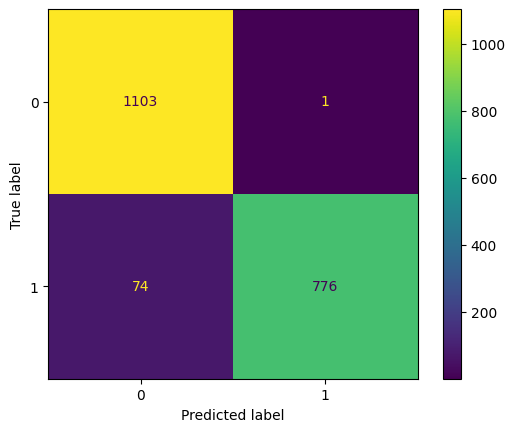

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred.astype(int))
plt.show()

In [ ]:
# Unsupervised beginning implementation
from sklearn.cluster import KMeans 
import numpy as np
print(df_slme.shape)
df_cluster= df_slme.select_dtypes(include = ["number"])
kmeans = KMeans(n_clusters = 4)
kmeans.fit_transform(df_cluster)
labels = kmeans.labels_
df_slme["labels"] = labels

df_cluster_list = [df_slme[df_slme["labels"] == i] for i in range(0,4)]
df_cluster_dict = dict(enumerate(df_cluster_list))

print (df_cluster_dict.items())




KeyboardInterrupt: 